In [0]:
!pip install seqeval

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=be44000882e61a7e719bdf39b7ea404405d76270ce46085de20ac81b877e16d6
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval


https://drive.google.com/open?id=1BYrNQQ_HAABbxvVUicfpqQ9h5eDJolPA

# Data Processing

In [3]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.drop(['POS'], axis =1)
data = data.fillna(method="ffill")
data.tail(12)

,Sentence #,Word,Tag
1048563,Sentence: 47958,exploded,O
1048564,Sentence: 47958,upon,O
1048565,Sentence: 47958,impact,O
1048566,Sentence: 47958,.,O
1048567,Sentence: 47959,Indian,B-gpe
1048568,Sentence: 47959,forces,O
1048569,Sentence: 47959,said,O
1048570,Sentence: 47959,they,O
1048571,Sentence: 47959,responded,O
1048572,Sentence: 47959,to,O


In [4]:
words = set(list(data['Word'].values))
words.add('PADword')
n_words = len(words)
n_words

35179

In [24]:
tags = list(set(data["Tag"].values))
n_tags = len(tags)
n_tags

17

In [0]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [7]:
getter = SentenceGetter(data)
sent = getter.get_next()
print(sent)

[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [8]:
sentences = getter.sentences
print(len(sentences))

47959


In [9]:
largest_sen = max(len(sen) for sen in sentences)
print('biggest sentence has {} words'.format(largest_sen))

biggest sentence has 104 words


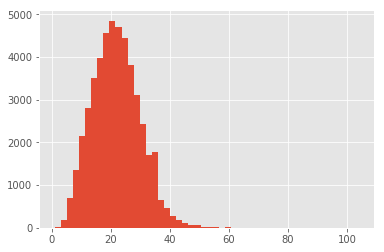

In [10]:
%matplotlib inline
plt.hist([len(sen) for sen in sentences], bins=50)
plt.show()

In [11]:
max_len = 50
X = [[w[0]for w in s] for s in sentences]
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PADword")
    new_X.append(new_seq)
new_X[15]

['Israeli',
 'officials',
 'say',
 'Prime',
 'Minister',
 'Ariel',
 'Sharon',
 'will',
 'undergo',
 'a',
 'medical',
 'procedure',
 'Thursday',
 'to',
 'close',
 'a',
 'tiny',
 'hole',
 'in',
 'his',
 'heart',
 'discovered',
 'during',
 'treatment',
 'for',
 'a',
 'minor',
 'stroke',
 'suffered',
 'last',
 'month',
 '.',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword']

In [12]:
from keras.preprocessing.sequence import pad_sequences
tags2index = {t:i for i,t in enumerate(tags)}
y = [[tags2index[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["O"])
y[15]

Using TensorFlow backend.


array([16, 11, 11,  1, 12, 12, 12, 11, 11, 11, 11, 11, 10, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
      dtype=int32)

# Build Model

In [0]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
X_tr, X_te, y_tr, y_te = train_test_split(new_X, y, test_size=0.1, random_state=2018)
sess = tf.Session()
K.set_session(sess)
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [0]:
batch_size = 32
def ElmoEmbedding(x):
    return elmo_model(inputs={"tokens": tf.squeeze(tf.cast(x,    tf.string)),"sequence_len": tf.constant(batch_size*[max_len])
                     },
                      signature="tokens",
                      as_dict=True)["elmo"]

In [15]:
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda
input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)
model = Model(input_text, out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
X_tr, X_val = X_tr[:1213*batch_size], X_tr[-135*batch_size:]
y_tr, y_val = y_tr[:1213*batch_size], y_tr[-135*batch_size:]
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)
history = model.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_val), y_val),batch_size=batch_size, epochs=1, verbose=1)

Train on 38816 samples, validate on 4320 samples
Epoch 1/1
 2880/38816 [=>............................] - ETA: 9:40 - loss: 0.0409 - acc: 0.9866

KeyboardInterrupt: ignored

# Evaluation

In [19]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
X_te = X_te[:149*batch_size]
test_pred = model.predict(np.array(X_te), verbose=1)

4768/4768 [==============================] - 52s 11ms/step


In [20]:
idx2tag = {i: w for w, i in tags2index.items()}
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out
def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = test2label(y_te[:149*32])
print(classification_report(test_labels, pred_labels))

           precision    recall  f1-score   support

      org       0.68      0.61      0.65      2061
      geo       0.81      0.91      0.85      3720
      per       0.73      0.79      0.76      1677
      tim       0.80      0.85      0.83      2148
      gpe       0.95      0.93      0.94      1591
      eve       0.42      0.24      0.31        33
      art       0.24      0.16      0.20        49
      nat       0.28      0.50      0.36        22

micro avg       0.79      0.82      0.81     11301
macro avg       0.79      0.82      0.80     11301



In [21]:
i = 390
p = model.predict(np.array(X_te[i:i+batch_size]))[0]
p = np.argmax(p, axis=-1)
print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
print("="*30)
for w, true, pred in zip(X_te[i], y_te[i], p):
    if w != "__PAD__":
        print("{:15}:{:5} ({})".format(w, tags[pred], tags[true]))

Word            Pred : (True)
Citing         :O     (O)
a              :O     (O)
draft          :O     (O)
report         :O     (O)
from           :O     (O)
the            :O     (O)
U.S.           :B-org (B-org)
Government     :I-org (I-org)
Accountability :I-org (O)
office         :O     (O)
,              :O     (O)
The            :B-org (B-org)
New            :I-org (I-org)
York           :I-org (I-org)
Times          :I-org (I-org)
said           :O     (O)
Saturday       :B-tim (B-tim)
the            :O     (O)
losses         :O     (O)
amount         :O     (O)
to             :O     (O)
between        :O     (O)
1,00,000       :O     (O)
and            :O     (O)
3,00,000       :O     (O)
barrels        :O     (O)
a              :O     (O)
day            :O     (O)
of             :O     (O)
Iraq           :B-geo (B-geo)
's             :O     (O)
declared       :O     (O)
oil            :O     (O)
production     :O     (O)
over           :O     (O)
the            :O     (O)
pa